In [8]:
import numpy as np
import numpy.typing as npt
from matplotlib import pyplot as plt
from scipy.special import erf
import os
import pandas as pd
from typing import Union
from sklearn.metrics import roc_curve, auc

import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Conv1D, MaxPooling1D, Flatten, Dense, Dropout, Masking, GlobalMaxPooling1D, Input
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

def EFP(time: np.int32 | npt.NDArray[np.int32], amplitude: np.float64, mu: np.float64, sigma: np.float64, tau: np.float64, a: np.float64, background: np.float64) -> np.float64 | npt.NDArray[np.float64]:
    Aprime = amplitude * sigma / (tau * np.sqrt(2 / np.pi))
    y1 = -(time - mu) / tau + sigma**2 / (2 * tau**2)
    y2 = (time - mu) / (np.sqrt(2) * sigma) - sigma / (np.sqrt(2) * tau)
    return Aprime * np.exp(y1) * (1 + erf(y2)) + a * time + background

def plot_flare(identifier: str, pred=None, act=None, save_dir=None):
    dirname = ''
    datafile = f'{dirname}flares/{identifier}.csv'
    df = pd.read_csv(datafile)
    summaryfile = f'{dirname}allflares_processed_5.csv'
    allcsv = pd.read_csv(summaryfile)
    row = allcsv[allcsv['identifier'] == identifier].iloc[0]

    fig, axs = plt.subplots(2, figsize=(9.6, 9.6), gridspec_kw={'height_ratios': [3, 1]})

    if act != None and pred != None:
        axs[0].set_title(f"{identifier}: pred: {pred}, actual: {act}")
    else:
        axs[0].set_title(f'{identifier}')
    plt.xlabel('Time (s)')
    plt.subplots_adjust(hspace=.0)
    linestyle = {"elinewidth":1, "capsize":0, "ecolor":"grey"}
    plt.setp(axs[0].get_xticklabels(), visible=False)

    xt = df['Time']
    yt = df['Counts']
    yerr = df['Error']

    axs[0].errorbar(xt, yt, yerr=yerr, fmt='D', ms=3, c='blue', **linestyle)

    for ax in axs:
        ax.tick_params(which='major', width=1)
        ax.tick_params(which='major', length=4)
        ax.margins(x=0)
    axs[0].set_ylabel('Flux (nW/m$^2$)')
    axs[1].set_ylabel('Residual ((o-f)/$\\sigma$)')
    axs[1].set_ylim(bottom=-4,top=4)

    range = (np.max(yt) - np.min(yt))/10
    axs[0].scatter(row['start_time'], \
        row['start_count'], c='k', s=30, zorder=15)
    axs[0].vlines(x=row['start_time'], \
        ymin=row['start_count'] - range, \
        ymax=row['end_count'] + range, color='k', linestyle='dotted', linewidth=2)
    axs[0].scatter(row['end_time'], \
        row['end_count'], c='k', s=30, zorder=15)
    axs[0].vlines(x=row['end_time'], \
        ymin=row['end_count'] - range, \
        ymax=row['end_count'] + range, color='k', linestyle='dotted', linewidth=2)

    yfit = EFP(xt, row['amplitude'], row['mu'], row['sigma'], row['tau'], row['slope'], row['background'])
    axs[0].plot(xt, yfit, c='r', zorder=10, lw=3)
    axs[0].tick_params(axis='x', direction='in')
    axs[1].errorbar(xt, (yt-yfit)/np.std(yt-yfit), yerr=yerr/np.std(yt-yfit), fmt='D', ms=3, c='blue', **linestyle)
    axs[1].axhline(np.mean((yt-yfit)/np.std(yt-yfit)), linestyle='--', lw=1, c='navy')

    if save_dir != None:
        plt.savefig(save_dir)

    plt.show()

In [60]:
import pandas as pd
from scipy.signal import welch
from tqdm import tqdm

class_info = pd.read_csv('sim6/fitted_flares.csv')
model1 = load_model('model1.keras')
val_set = np.genfromtxt('val_ind.txt')

fprs = []
tprs = []
aucs = []
mse_a = np.array([])
mse_b = np.array([])

for c in range(10):
    data = []
    labels = []
    labels_out = []
    ids = []
    peak_count = []
    
    tot_flares = 0
    maxlen = 0
    
    lotto_ind = np.random.choice(np.arange(len(val_set)), len(val_set)//3, replace=False)
    lotto = val_set[lotto_ind]
    
    for i, iden in enumerate(tqdm(np.array(class_info['identifier']))):
        if i not in val_set:
            continue
        
        try:
            tod = pd.read_csv('sim6/binned_flares/' + str(iden) + '.csv')
        except FileNotFoundError:
            continue
    
        flag = False
        if i in lotto:
            
            num_to_add = np.random.randint(1, 4)
            ind_to_add = []
    
            counter = 0
            while len(ind_to_add) <= num_to_add and counter < 100:
                counter += 1
                
                ind = np.random.randint(1, len(class_info))
    
                if ind in ind_to_add:
                    continue
    
                tod_to_add = pd.read_csv(f"sim6/binned_flares/{class_info['identifier'][ind]}.csv")
    
                if len(tod_to_add['Counts']) > len(tod['Counts']):
                    continue
    
                if class_info['peak_count'][i] > 3*class_info['peak_count'][ind] or class_info['peak_count'][i] < class_info['peak_count'][ind]:
                    continue
    
                if np.max(tod_to_add['Time']) - np.min(tod_to_add['Time']) > 0.6*(np.max(tod['Time']) - np.min(tod['Time'])):
                    continue
    
                n_zeros = len(tod['Counts']) - len(tod_to_add['Counts'])
    
                if n_zeros == 0:
                    arr_to_add = np.array(tod_to_add['Counts'])*np.hanning(len(tod_to_add['Counts']))
                else:
                    lead_or_trail = np.random.randint(0, 2)
    
                    if lead_or_trail == 0:
                        n_leading = n_zeros
                        n_trailing = 0
                    else:
                        n_leading = 0
                        n_trailing = n_zeros
        
                    arr_to_add = np.pad(np.array(tod_to_add['Counts'])*np.hanning(len(tod_to_add['Counts'])), (n_leading, n_trailing), 'constant', constant_values=(0, 0))
    
                tod['Counts'] = np.array(tod['Counts']) + arr_to_add
                tod['Counts'] /= np.max(tod['Counts'])
    
                flag = True
    
                ind_to_add.append(ind)
    
        if flag:
            plt.figure(figsize=(3.5, 2.5))
            plt.tick_params(axis='both', which='major', labelsize=8)
            
            plt.scatter(tod['Time'], tod['Counts'], s=0.5)

            plt.xlabel('Time (s)', fontsize=9)
            plt.ylabel('Intensity (nW/m$^2$)', fontsize=9)

            plt.savefig('multiflares/' + str(iden) + '.pdf', bbox_inches='tight', pad_inches=0.01)

            plt.close()
            
            labels_out.append(1)
        else:
            labels_out.append(0)
    
        if len(tod['Counts']) > maxlen:
            maxlen = len(tod['Counts'])
    
        tot_flares += 1
        data.append(list(tod['Counts']))
        data_deriv.append(list(np.diff(tod['Counts'])))
        peak_count.append(class_info['peak_count'][i])
        
        if class_info['flare_type'][i] == 'A':
            labels.append(0)
        else:
            labels.append(1)
    
        ids.append(class_info['identifier'][i])
    
    data = pad_sequences(data, padding='post', dtype=float, maxlen=2089)   # the padding is to adjust the shape of the np arrays

    preds = model1.predict(np.expand_dims(data, axis=-1))

    mse = (preds.flatten() - np.array(labels))**2

    fpr, tpr, thresh = roc_curve(labels_out, mse)
    auc_val = auc(fpr, tpr)

    fprs.append(fpr)
    tprs.append(tpr)
    aucs.append(auc_val)
    mse_a = np.concatenate((mse_a, mse[np.array(labels_out)==0]))
    mse_b = np.concatenate((mse_b, mse[np.array(labels_out)==1]))

/home/mrchu/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:877: UserWarning: Layer 'conv1d_153' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
100%|██████████████████████████████████████| 8716/8716 [00:33<00:00, 260.64it/s]
/home/mrchu/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:877: UserWarning: Layer 'conv1d_153' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1090 1090
2 170
7 7


100%|██████████████████████████████████████| 8716/8716 [00:39<00:00, 218.12it/s]

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


1090 1090
2 175
7 7


100%|██████████████████████████████████████| 8716/8716 [00:37<00:00, 231.79it/s]

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


1090 1090
2 173
7 7


100%|██████████████████████████████████████| 8716/8716 [00:36<00:00, 235.66it/s]

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


1090 1090
2 169
7 7


100%|██████████████████████████████████████| 8716/8716 [00:35<00:00, 242.23it/s]


35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1090 1090
2 169
7 7


100%|██████████████████████████████████████| 8716/8716 [00:36<00:00, 241.94it/s]

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


1090 1090
2 175
7 7


100%|██████████████████████████████████████| 8716/8716 [00:35<00:00, 246.94it/s]


35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1090 1090
2 176
7 7


100%|██████████████████████████████████████| 8716/8716 [00:34<00:00, 255.12it/s]

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


1090 1090
2 172
7 7


100%|██████████████████████████████████████| 8716/8716 [00:34<00:00, 255.80it/s]


35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1090 1090
2 159
7 7


100%|██████████████████████████████████████| 8716/8716 [00:32<00:00, 272.23it/s]

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1090 1090
2 159
7 7


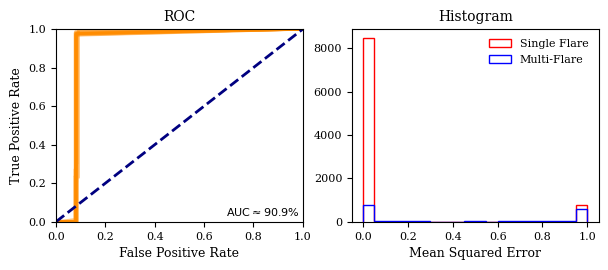

In [61]:
plt.rcParams['font.family'] = 'serif'

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 2.5))

for c in range(10):
    ax1.plot(fprs[c], tprs[c], color='darkorange', lw=2, alpha=0.5)

ax1.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

ax1.text(0.99, 0.03, r"$\mathrm{AUC} \approx " + str(np.round(np.mean(aucs)*100, 1)) + '\%$', ha='right', transform=ax1.transAxes, fontsize=8)

ax1.set_xlim([0.0, 1.0])
ax1.set_ylim([0.0, 1.0])

ax1.set_xlabel('False Positive Rate', fontsize=9)
ax1.set_ylabel('True Positive Rate', fontsize=9)
ax1.set_title('ROC', fontsize=10)

ax1.tick_params(axis='both', which='major', labelsize=8)

ax2.hist(mse_a, bins=np.linspace(0, 1, 21), histtype='step', color='r', label='Single Flare')
ax2.hist(mse_b, bins=np.linspace(0, 1, 21), histtype='step', color='b', label='Multi-Flare')

ax2.legend(fontsize=8, loc='upper right', frameon=False)

ax2.set_xlabel('Mean Squared Error', fontsize=9)

ax2.set_title('Histogram', fontsize=10)

ax2.tick_params(axis='both', which='major', labelsize=8)

plt.savefig('anomaly.pdf', bbox_inches='tight', pad_inches=0.01)

plt.show()